<a href="https://colab.research.google.com/github/andrewcxjin/aipi520-project1/blob/main/AIPI520_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIPI 520 Project 1**
**Andrew Jin, Diya Mirji, Danny Ross**

This notebook contains the work we did to predict the temperature at RDU from 09/17/2025 - 09/30/2025. It shows the process of our data collection, feature engineering, model training, and performance evaluation.

In [ ]:
# Remove Colab default sample_data
!rm -r ./sample_data

In [ ]:
# Install packages
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

## Data Collection
- https://dev.meteostat.net/bulk/; https://dev.meteostat.net/formats.html#time-format
  - Hourly weather from RDU from Sep 17-30 2025 ==> test data
  - Hourly weather from RDU from Sep 17-30 2024
  - Hourly weather from RDU from Sep 17-30 2023
  - Hourly weather from RDU from Sep 17-30 2022
  - Hourly weather from RDU from Sep 17-30 2021
  - Hourly weather from RDU from Sep 17-30 2020

In [ ]:
#Download bulk data
!curl "https://data.meteostat.net/hourly/2025/72306.csv.gz" --output "RDU-2025.csv.gz"
!curl "https://data.meteostat.net/hourly/2024/72306.csv.gz" --output "RDU-2024.csv.gz"
!curl "https://data.meteostat.net/hourly/2023/72306.csv.gz" --output "RDU-2023.csv.gz"
!curl "https://data.meteostat.net/hourly/2022/72306.csv.gz" --output "RDU-2022.csv.gz"
!curl "https://data.meteostat.net/hourly/2021/72306.csv.gz" --output "RDU-2021.csv.gz"
!curl "https://data.meteostat.net/hourly/2020/72306.csv.gz" --output "RDU-2020.csv.gz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80524  100 80524    0     0   175k      0 --:--:-- --:--:-- --:--:--  175k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 98255  100 98255    0     0   271k      0 --:--:-- --:--:-- --:--:--  271k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 97274  100 97274    0     0   216k      0 --:--:-- --:--:-- --:--:--  216k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96066  100 96066    0     0   163k      0 --:--:-- --:--:-- --:--:--  163k
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
# Load data into dataframes
dfs = []
test_df = pd.read_csv('RDU-2025.csv.gz')
dfs.append(test_df)
df_2024 = pd.read_csv('RDU-2024.csv.gz')
dfs.append(df_2024)
df_2023 = pd.read_csv('RDU-2023.csv.gz')
dfs.append(df_2023)
df_2022 = pd.read_csv('RDU-2022.csv.gz')
dfs.append(df_2022)
df_2021 = pd.read_csv('RDU-2021.csv.gz')
dfs.append(df_2021)
df_2020 = pd.read_csv('RDU-2020.csv.gz')
dfs.append(df_2020)
print(df_2020.head())
print(df_2020.shape, df_2021.shape, test_df.shape)

   year  month  day  hour  temp temp_source  rhum rhum_source  prcp  \
0  2020      1    1     0   8.3    isd_lite    54    isd_lite   NaN   
1  2020      1    1     1   7.2    isd_lite    58    isd_lite   0.0   
2  2020      1    1     2   6.7    isd_lite    62    isd_lite   0.0   
3  2020      1    1     3   8.9    isd_lite    56    isd_lite   0.0   
4  2020      1    1     4   6.7    isd_lite    62    isd_lite   0.0   

  prcp_source  ...  wspd wspd_source  wpgt wpgt_source    pres  pres_source  \
0         NaN  ...  13.0    isd_lite   NaN         NaN  1009.3     isd_lite   
1    isd_lite  ...  16.6    isd_lite   NaN         NaN  1009.5     isd_lite   
2    isd_lite  ...   9.4    isd_lite   NaN         NaN  1009.8     isd_lite   
3    isd_lite  ...   7.6    isd_lite   NaN         NaN  1010.1     isd_lite   
4    isd_lite  ...   0.0    isd_lite   NaN         NaN  1010.7     isd_lite   

   cldc cldc_source  coco coco_source  
0   NaN         NaN     2  dwd_mosmix  
1   0.0    isd_lit

In [ ]:
# Only keep year, month, day, hour, temp for each df and create datetime index
for i in range(len(dfs)):
  dfs[i] = dfs[i][['year', 'month', 'day', 'hour', 'temp']]
  dfs[i].index = pd.to_datetime(dfs[i][['year', 'month', 'day', 'hour']])

print(dfs[0].head())
print(dfs[0].index.to_list()[-1])

                     year  month  day  hour  temp
2025-01-01 00:00:00  2025      1    1     0  15.0
2025-01-01 01:00:00  2025      1    1     1  13.9
2025-01-01 02:00:00  2025      1    1     2  14.4
2025-01-01 03:00:00  2025      1    1     3  13.3
2025-01-01 04:00:00  2025      1    1     4  12.2
2025-10-24 21:00:00


In [ ]:
# Remove observations after 10/1/25
dfs[0] = dfs[0][dfs[0].index < '2025-10-01 00:00:00']

for i in range(len(dfs)):
    print(dfs[i].shape)

(6552, 5)
(8784, 5)
(8760, 5)
(8760, 5)
(8760, 5)
(8784, 5)


In [ ]:
# Stack all dfs from each year
all_df = pd.concat(dfs[-1::-1],ignore_index=False)
print(all_df.head())
print(all_df.shape)
print(all_df.index.to_list()[-1])

                     year  month  day  hour  temp
2020-01-01 00:00:00  2020      1    1     0   8.3
2020-01-01 01:00:00  2020      1    1     1   7.2
2020-01-01 02:00:00  2020      1    1     2   6.7
2020-01-01 03:00:00  2020      1    1     3   8.9
2020-01-01 04:00:00  2020      1    1     4   6.7
(50400, 5)
2025-09-30 23:00:00


In [ ]:
# Split into train df and test df
train_df = all_df[all_df.index < '2025-09-17 00:00:00']
test_df = all_df[all_df.index >= '2025-09-17 00:00:00']
print(train_df.shape, test_df.shape)

(50064, 5) (336, 5)


In [ ]:
# Check that train and test df have correct date ranges
print(train_df.head())
print(train_df.index.to_list()[-1])
print(test_df.head())
print(test_df.index.to_list()[-1])

                     year  month  day  hour  temp
2020-01-01 00:00:00  2020      1    1     0   8.3
2020-01-01 01:00:00  2020      1    1     1   7.2
2020-01-01 02:00:00  2020      1    1     2   6.7
2020-01-01 03:00:00  2020      1    1     3   8.9
2020-01-01 04:00:00  2020      1    1     4   6.7
2025-09-16 23:00:00
                     year  month  day  hour  temp
2025-09-17 00:00:00  2025      9   17     0  17.0
2025-09-17 01:00:00  2025      9   17     1  17.0
2025-09-17 02:00:00  2025      9   17     2  17.0
2025-09-17 03:00:00  2025      9   17     3  17.0
2025-09-17 04:00:00  2025      9   17     4  17.0
2025-09-30 23:00:00


## Exploratory Data Analysis

In [ ]:
# Show data structure
print(f"Dimensions: {train_df.shape}")
print(f"Data Types:\n{train_df.dtypes}")
print(f"Missing Values:\n{train_df.isnull().sum()*100/train_df.shape[0]}")
print()
print(f"Dimensions: {test_df.shape}")
print(f"Data Types:\n{test_df.dtypes}")
print(f"Missing Values:\n{test_df.isnull().sum()*100/test_df.shape[0]}")

Dimensions: (50064, 5)
Data Types:
year       int64
month      int64
day        int64
hour       int64
temp     float64
dtype: object
Missing Values:
year     0.0
month    0.0
day      0.0
hour     0.0
temp     0.0
dtype: float64

Dimensions: (336, 5)
Data Types:
year       int64
month      int64
day        int64
hour       int64
temp     float64
dtype: object
Missing Values:
year     0.0
month    0.0
day      0.0
hour     0.0
temp     0.0
dtype: float64


mean    17.233653
50%     18.300000
Name: temp, dtype: float64
==skewness==
-0.2989150775817737
==kurtness==
-0.6605406333287958


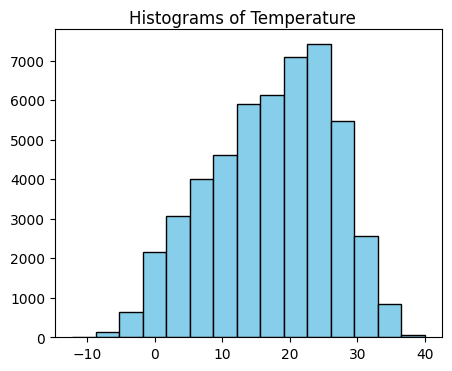

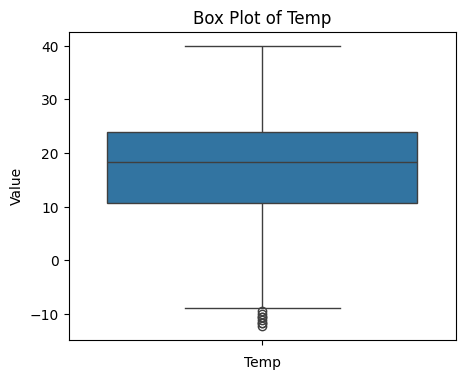

In [ ]:
# Obtain statistics
print(train_df['temp'].describe().loc[['mean', '50%']])

print("==skewness==")
print(train_df['temp'].skew())
print("==kurtness==")
print(train_df['temp'].kurt())

# Historgram to view distribution
train_df['temp'].hist(bins=15, figsize=(5,4), grid=False, color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Temperature', y=0.93)
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(5, 4))
sns.boxplot(data=train_df['temp'])
plt.title('Box Plot of Temp')
plt.xlabel('Temp')
plt.ylabel('Value')
plt.show()

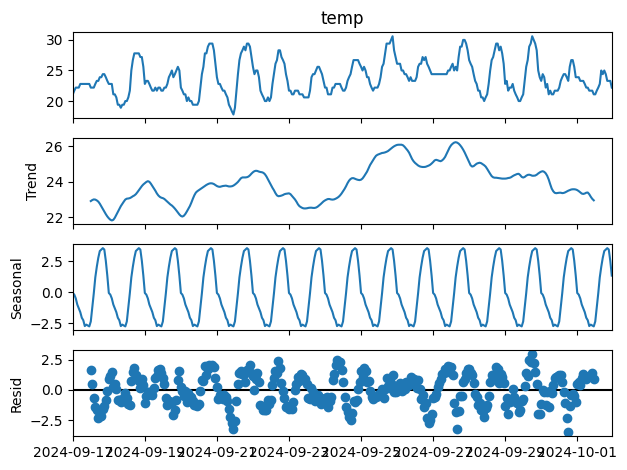

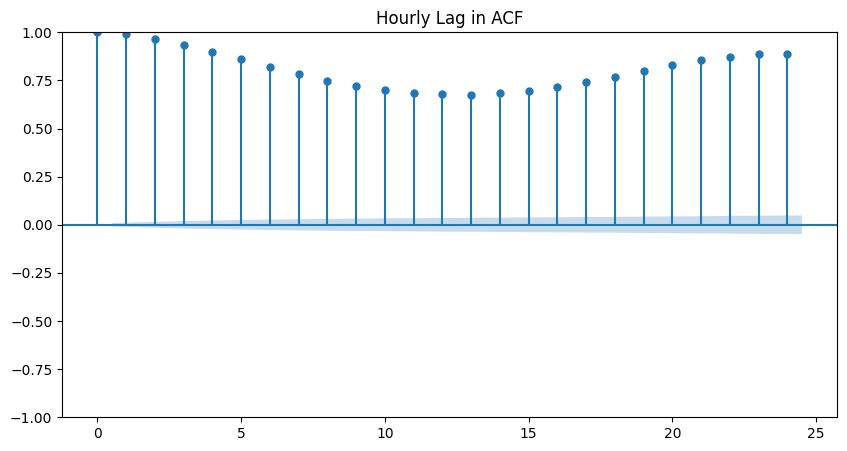

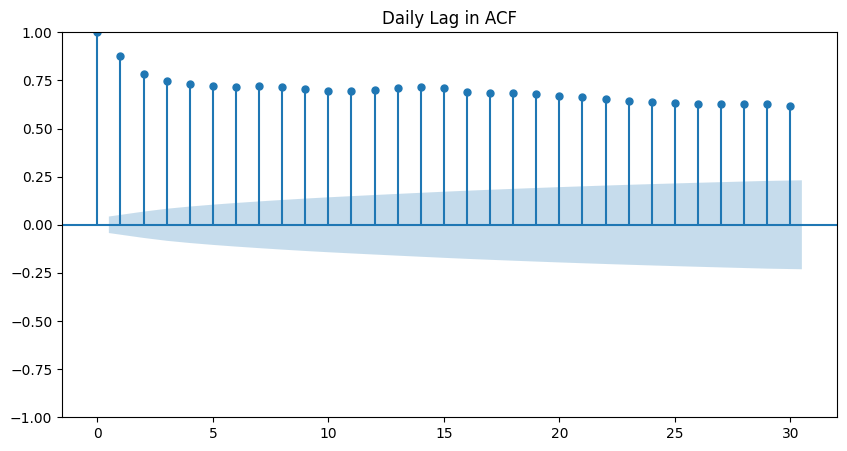

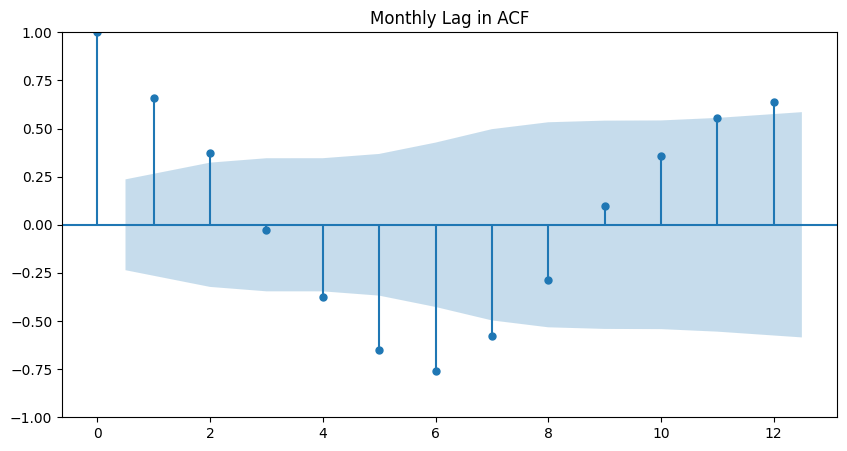

In [ ]:
# Time series decomposition
df_input_viz = train_df['temp']
df_input_viz = df_input_viz['2024-09-17':'2024-10-01']
decomposition = sm.tsa.seasonal_decompose(df_input_viz, model = 'additive',period=24)
decomposition.plot()
plt.show()

# Autocorrelation
plt.rcParams['figure.figsize'] = [10,5]
df_input_viz = train_df['temp']
plot_acf(df_input_viz,lags=24)
plt.title('Hourly Lag in ACF')
plt.show()

df_input_viz = train_df['temp']
df_input_viz = df_input_viz[df_input_viz.index.hour==12]
plot_acf(df_input_viz,lags=30)
plt.title('Daily Lag in ACF')
plt.show()

df_input_viz = train_df['temp']
df_input_viz = df_input_viz[df_input_viz.index.hour==12]
df_input_viz = df_input_viz[df_input_viz.index.day==12]
plot_acf(df_input_viz,lags=12)
plt.title('Monthly Lag in ACF')
plt.show()

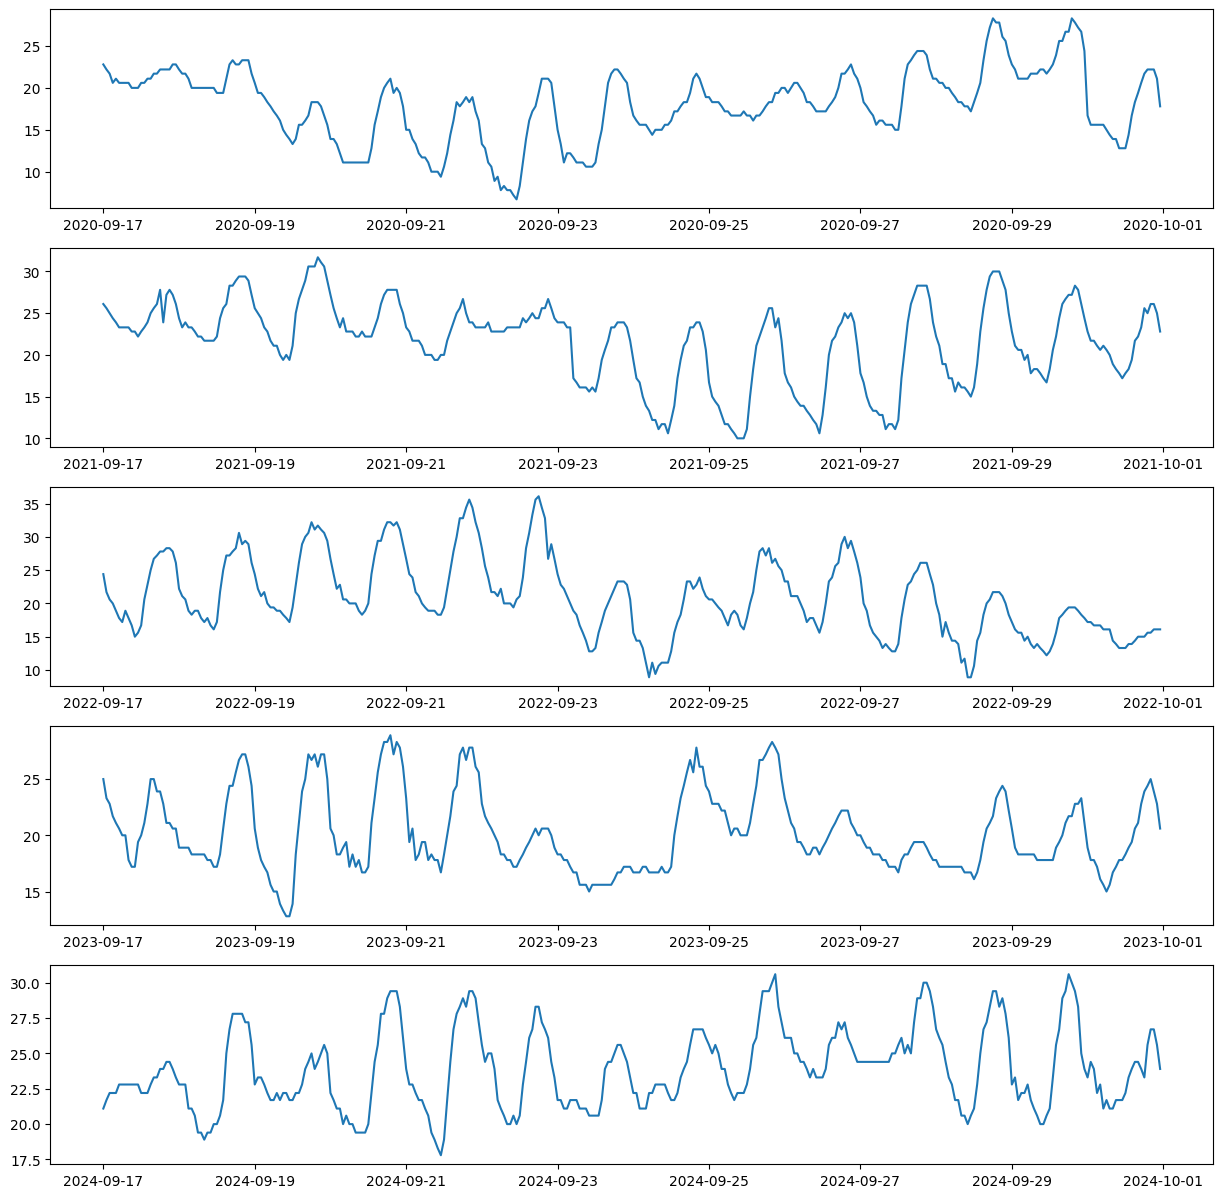

In [ ]:
# Time series visualization on RDU data only
temp_per_hour = train_df['temp']

fig, axes = plt.subplots(5, 1, figsize=(15, 15))
axes.flatten()
axes[0].plot(temp_per_hour['2020-09-17 00:00:00':'2020-09-30 23:00:00'])
axes[1].plot(temp_per_hour['2021-09-17 00:00:00':'2021-09-30 23:00:00'])
axes[2].plot(temp_per_hour['2022-09-17 00:00:00':'2022-09-30 23:00:00'])
axes[3].plot(temp_per_hour['2023-09-17 00:00:00':'2023-09-30 23:00:00'])
axes[4].plot(temp_per_hour['2024-09-17 00:00:00':'2024-09-30 23:00:00'])


In [ ]:
# Split into train and test
X_train = train_df.drop(columns=['temp'])
y_train = train_df['temp']
X_test = test_df.drop(columns=['temp'])
y_test = test_df['temp']

## Linear Regression Model

In [ ]:
#Baseline linear model with no other features
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
baseline_preds = baseline_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, baseline_preds)
mae = mean_absolute_error(y_test, baseline_preds)
r2 = r2_score(y_test, baseline_preds)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

MSE: 22.76
MAE: 3.78
R2: -0.18


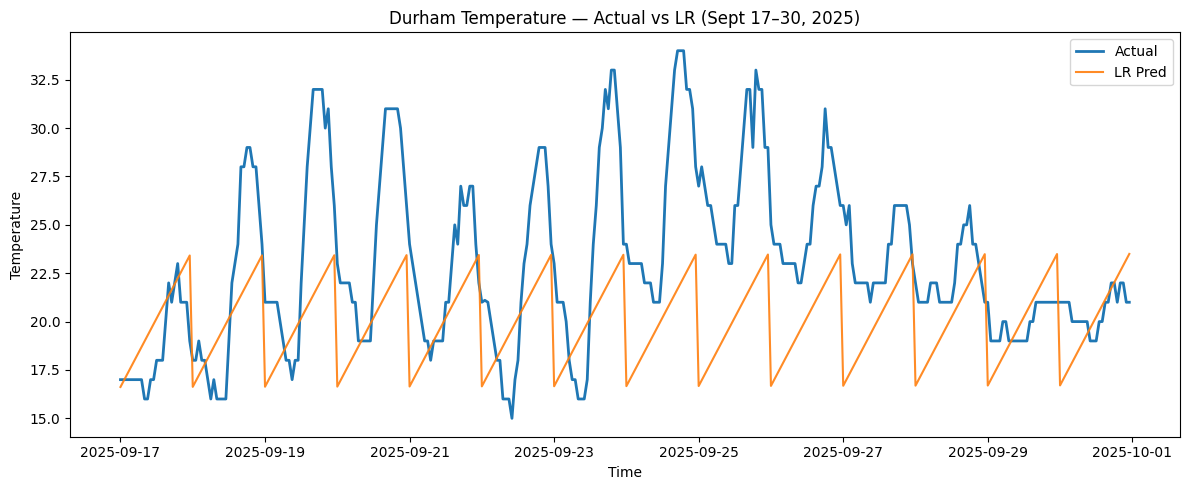

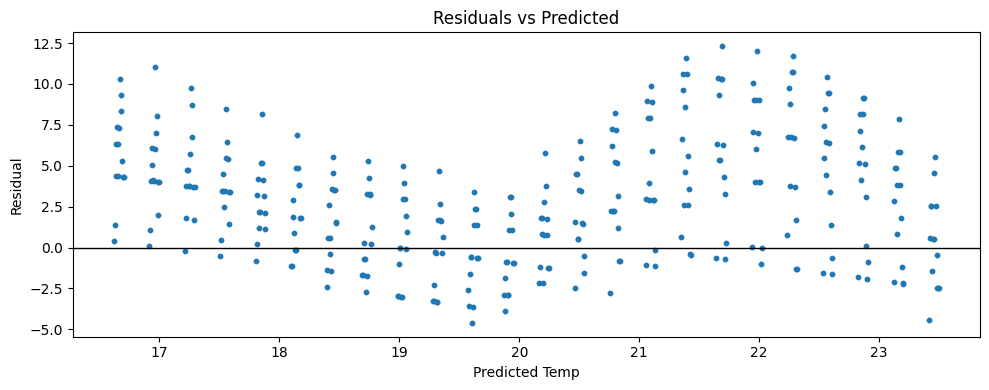

In [ ]:
# Plot actual vs. predicted
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
plt.plot(y_test.index, baseline_preds, label="LR Pred", alpha=0.9)
plt.title("Durham Temperature — Actual vs LR (Sept 17–30, 2025)")
plt.xlabel("Time"); plt.ylabel("Temperature")
plt.legend(); plt.tight_layout(); plt.show()

# Plot residuals
residuals = y_test.values - baseline_preds
plt.figure(figsize=(10,4))
plt.scatter(baseline_preds, residuals, s=10)
plt.axhline(0, color="k", linewidth=1)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Temp"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()


In [ ]:
# Create new df for feature engineering
linmodel_train = X_train.copy()
linmodel_train.head()

,year,month,day,hour
2020-01-01 00:00:00,2020,1,1,0
2020-01-01 01:00:00,2020,1,1,1
2020-01-01 02:00:00,2020,1,1,2
2020-01-01 03:00:00,2020,1,1,3
2020-01-01 04:00:00,2020,1,1,4


In [ ]:
# Add calendar features to train df
linmodel_train["dayofyear"] = linmodel_train.index.dayofyear
linmodel_train["dayofweek"] = linmodel_train.index.dayofweek
linmodel_train["hour_sin"] = np.sin(2*np.pi*linmodel_train["hour"]/24)
linmodel_train["hour_cos"] = np.cos(2*np.pi*linmodel_train["hour"]/24)
linmodel_train["doy_sin"]  = np.sin(2*np.pi*linmodel_train["dayofyear"]/365.25)
linmodel_train["doy_cos"]  = np.cos(2*np.pi*linmodel_train["dayofyear"]/365.25)

for k in [2, 3]:
    linmodel_train[f"hour_sin_{k}"] = np.sin(2*np.pi*k*linmodel_train["hour"]/24)
    linmodel_train[f"hour_cos_{k}"] = np.cos(2*np.pi*k*linmodel_train["hour"]/24)
    linmodel_train[f"doy_sin_{k}"]  = np.sin(2*np.pi*k*linmodel_train["dayofyear"]/365.25)
    linmodel_train[f"doy_cos_{k}"]  = np.cos(2*np.pi*k*linmodel_train["dayofyear"]/365.25)

linmodel_train["month_sin"] = np.sin(2*np.pi*linmodel_train["month"]/12)
linmodel_train["month_cos"] = np.cos(2*np.pi*linmodel_train["month"]/12)

# Add same calendar features to test df
linmodel_test = X_test.copy()

linmodel_test["dayofyear"] = linmodel_test.index.dayofyear
linmodel_test["dayofweek"] = linmodel_test.index.dayofweek
linmodel_test["hour_sin"] = np.sin(2*np.pi*linmodel_test["hour"]/24)
linmodel_test["hour_cos"] = np.cos(2*np.pi*linmodel_test["hour"]/24)
linmodel_test["doy_sin"]  = np.sin(2*np.pi*linmodel_test["dayofyear"]/365.25)
linmodel_test["doy_cos"]  = np.cos(2*np.pi*linmodel_test["dayofyear"]/365.25)

for k in [2, 3]:
    linmodel_test[f"hour_sin_{k}"] = np.sin(2*np.pi*k*linmodel_test["hour"]/24)
    linmodel_test[f"hour_cos_{k}"] = np.cos(2*np.pi*k*linmodel_test["hour"]/24)
    linmodel_test[f"doy_sin_{k}"]  = np.sin(2*np.pi*k*linmodel_test["dayofyear"]/365.25)
    linmodel_test[f"doy_cos_{k}"]  = np.cos(2*np.pi*k*linmodel_test["dayofyear"]/365.25)

linmodel_test["month_sin"] = np.sin(2*np.pi*linmodel_test["month"]/12)
linmodel_test["month_cos"] = np.cos(2*np.pi*linmodel_test["month"]/12)

In [ ]:
# Using autocorrelation lags from EDA
# Just from previous hour and previous day at same hour and previous years at same hour
for i in linmodel_train.index:
  if i - pd.DateOffset(years=1) in all_df.index:
    linmodel_train.loc[i, "previous_hour_temp"] = all_df.loc[i-pd.Timedelta(hours=1), 'temp']
    linmodel_train.loc[i, "previous_day_temp"] = all_df.loc[i-pd.Timedelta(days=1), 'temp']
    linmodel_train.loc[i, "previous_year_temp"] = all_df.loc[i-pd.DateOffset(years=1), 'temp']
linmodel_train = linmodel_train.iloc[(24*366):]
linmodel_y_train = y_train.copy()
linmodel_y_train = linmodel_y_train.iloc[(24*366):]

for i in linmodel_test.index:
  linmodel_test.loc[i, "previous_hour_temp"] = all_df.loc[i-pd.Timedelta(hours=1), 'temp']
  linmodel_test.loc[i, "previous_day_temp"] = all_df.loc[i-pd.Timedelta(days=1), 'temp']
  linmodel_test.loc[i, "previous_year_temp"] = all_df.loc[i-pd.DateOffset(years=1), 'temp']

In [ ]:
# Fit model and calculate metrics
print(linmodel_train.shape, linmodel_y_train.shape)
lr_model_1 = LinearRegression()
lr_model_1.fit(linmodel_train, linmodel_y_train)
lr1_preds = lr_model_1.predict(linmodel_test)

mse = mean_squared_error(y_test, lr1_preds)
mae = mean_absolute_error(y_test, lr1_preds)
r2 = r2_score(y_test, lr1_preds)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

(41280, 23) (41280,)
MSE: 1.11
MAE: 0.82
R2: 0.94


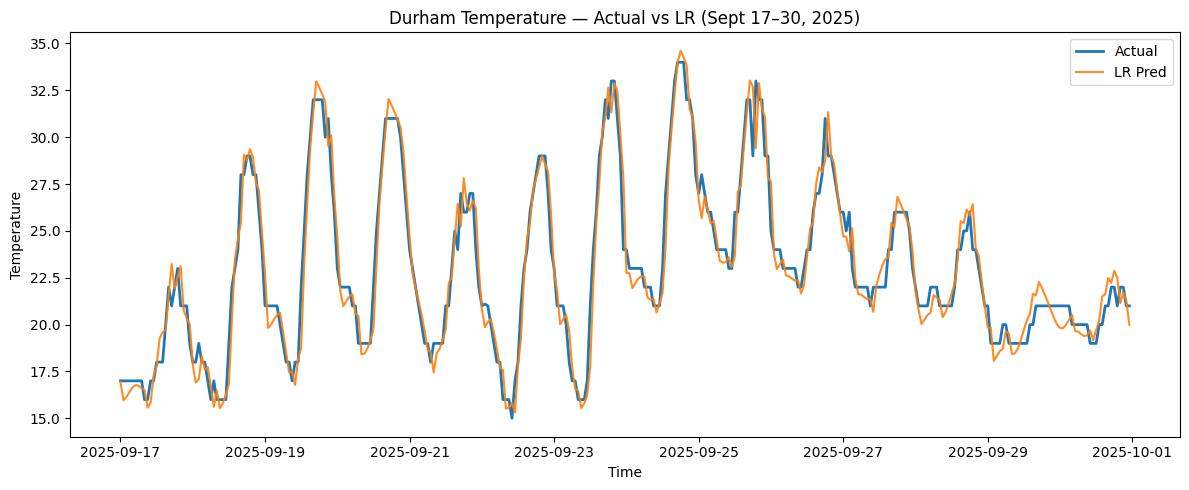

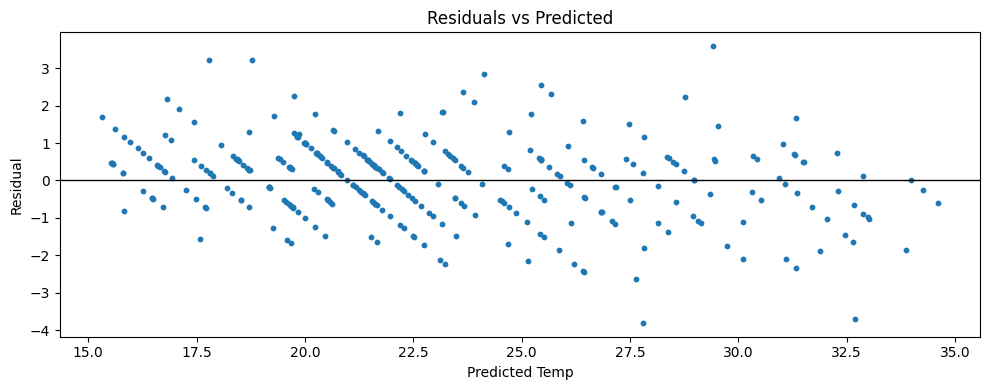

In [ ]:
# Plot actual vs. predicted
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
plt.plot(y_test.index, lr1_preds, label="LR Pred", alpha=0.9)
plt.title("Durham Temperature — Actual vs LR (Sept 17–30, 2025)")
plt.xlabel("Time"); plt.ylabel("Temperature")
plt.legend(); plt.tight_layout(); plt.show()

# Plot residuals
residuals = y_test.values - lr1_preds
plt.figure(figsize=(10,4))
plt.scatter(lr1_preds, residuals, s=10)
plt.axhline(0, color="k", linewidth=1)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Temp"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

In [ ]:
# Coefficients of our model
coef = lr_model_1.coef_
intercept = lr_model_1.intercept_

# Print out the equation
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,linmodel_train.columns)])
print(equation)

y = -8.922 + 0.005*year + -0.233*month + -0.007*day + -0.001*hour + 0.008*dayofyear + -0.003*dayofweek + -0.791*hour_sin + -0.821*hour_cos + -0.030*doy_sin + -0.192*doy_cos + 0.428*hour_sin_2 + -0.255*hour_cos_2 + 0.022*doy_sin_2 + -0.012*doy_cos_2 + -0.143*hour_sin_3 + -0.111*hour_cos_3 + 0.001*doy_sin_3 + -0.009*doy_cos_3 + 0.023*month_sin + -0.012*month_cos + 0.972*previous_hour_temp + 0.006*previous_day_temp + 0.002*previous_year_temp


In [ ]:
# Try Ridge regression if there are any unnecessary features
scaler = StandardScaler()
linmodel_train_scaled = scaler.fit_transform(linmodel_train)
linmodel_test_scaled = scaler.transform(linmodel_test)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(linmodel_train_scaled, linmodel_y_train)
ridge_preds = ridge_model.predict(linmodel_test_scaled)

mse = mean_squared_error(y_test, ridge_preds)
mae = mean_absolute_error(y_test, ridge_preds)
r2 = r2_score(y_test, ridge_preds)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")


MSE: 1.11
MAE: 0.82
R2: 0.94


^Looks like no change with ridge regularization.

## Linear Regression Model (Kyoto)

In [3]:
# Load dataset and separate into years
!curl "https://data.meteostat.net/hourly/2025/47759.csv.gz" --output "Kyoto-2025.csv.gz"
!curl "https://data.meteostat.net/hourly/2024/47759.csv.gz" --output "Kyoto-2024.csv.gz"
!curl "https://data.meteostat.net/hourly/2023/47759.csv.gz" --output "Kyoto-2023.csv.gz"
!curl "https://data.meteostat.net/hourly/2022/47759.csv.gz" --output "Kyoto-2022.csv.gz"
!curl "https://data.meteostat.net/hourly/2021/47759.csv.gz" --output "Kyoto-2021.csv.gz"
!curl "https://data.meteostat.net/hourly/2020/47759.csv.gz" --output "Kyoto-2020.csv.gz"


df_kyoto2025 = pd.read_csv('Kyoto-2025.csv.gz')
df_kyoto2025['datetime'] = pd.to_datetime(df_kyoto2025[['year', 'month', 'day', 'hour']])
df_kyoto2025 = df_kyoto2025[(df_kyoto2025['datetime'] < '2025-10-01 00:00:00')]
df_kyoto2025.set_index('datetime', inplace=True) #sets the df index to datetime

df_kyoto2024 = pd.read_csv('Kyoto-2024.csv.gz')
df_kyoto2024['datetime'] = pd.to_datetime(df_kyoto2024[['year', 'month', 'day', 'hour']])
df_kyoto2024.set_index('datetime', inplace=True) #sets the df index to datetime

df_kyoto2023 = pd.read_csv('Kyoto-2023.csv.gz')
df_kyoto2023['datetime'] = pd.to_datetime(df_kyoto2023[['year', 'month', 'day', 'hour']])
df_kyoto2023.set_index('datetime', inplace=True) #sets the df index to datetime

df_kyoto2022 = pd.read_csv('Kyoto-2022.csv.gz')
df_kyoto2022['datetime'] = pd.to_datetime(df_kyoto2022[['year', 'month', 'day', 'hour']])
df_kyoto2022.set_index('datetime', inplace=True) #sets the df index to datetime

df_kyoto2021 = pd.read_csv('Kyoto-2021.csv.gz')
df_kyoto2021['datetime'] = pd.to_datetime(df_kyoto2021[['year', 'month', 'day', 'hour']])
df_kyoto2021.set_index('datetime', inplace=True) #sets the df index to datetime

df_kyoto2020 = pd.read_csv('Kyoto-2020.csv.gz')
df_kyoto2020['datetime'] = pd.to_datetime(df_kyoto2020[['year', 'month', 'day', 'hour']])
df_kyoto2020.set_index('datetime', inplace=True) #sets the df index to datetime

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86827  100 86827    0     0   329k      0 --:--:-- --:--:-- --:--:--  329k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  102k  100  102k    0     0   679k      0 --:--:-- --:--:-- --:--:--  681k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  102k  100  102k    0     0   747k      0 --:--:-- --:--:-- --:--:--  750k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   98k  100   98k    0     0   715k      0 --:--:-- --:--:-- --:--:--  718k
  % Total    % Received % Xferd  Average Speed   Tim

In [4]:
# Create test set from RDU data
!curl "https://data.meteostat.net/hourly/2025/72306.csv.gz" --output "RDU-2025.csv.gz"

test_df = pd.read_csv('RDU-2025.csv.gz')
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df = test_df[(test_df['datetime'] >= '2025-09-17 00:00:00') & (test_df['datetime'] <= '2025-09-30 23:00:00')]
test_df.drop(columns=['rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'cldc', 'wpgt'], inplace=True)
test_df = test_df[[col for col in test_df.columns if not col.endswith('_source')]]
test_df.set_index('datetime', inplace=True) #sets the df index to datetime
test_df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80524  100 80524    0     0   171k      0 --:--:-- --:--:-- --:--:--  171k


,year,month,day,hour,temp
datetime,,,,,
2025-09-17 00:00:00,2025,9,17,0,17.0
2025-09-17 01:00:00,2025,9,17,1,17.0
2025-09-17 02:00:00,2025,9,17,2,17.0
2025-09-17 03:00:00,2025,9,17,3,17.0
2025-09-17 04:00:00,2025,9,17,4,17.0


In [5]:
# Concatenate Kyoto datasets
kyoto_total_df = pd.concat([df_kyoto2020, df_kyoto2021, df_kyoto2022, df_kyoto2023, df_kyoto2024, df_kyoto2025],ignore_index=False)
kyoto_train_df = kyoto_total_df.copy()
kyoto_train_df = kyoto_train_df[kyoto_train_df.index < '2025-09-17 00:00:00']
kyoto_train_df.drop(columns=['rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'cldc'], inplace=True)
kyoto_train_df = kyoto_train_df[[col for col in kyoto_train_df.columns if not col.endswith('_source')]]
kyoto_train_df.head()

,year,month,day,hour,temp
datetime,,,,,
2020-01-01 00:00:00,2020,1,1,0,6.3
2020-01-01 01:00:00,2020,1,1,1,7.2
2020-01-01 02:00:00,2020,1,1,2,8.1
2020-01-01 03:00:00,2020,1,1,3,8.1
2020-01-01 04:00:00,2020,1,1,4,8.3


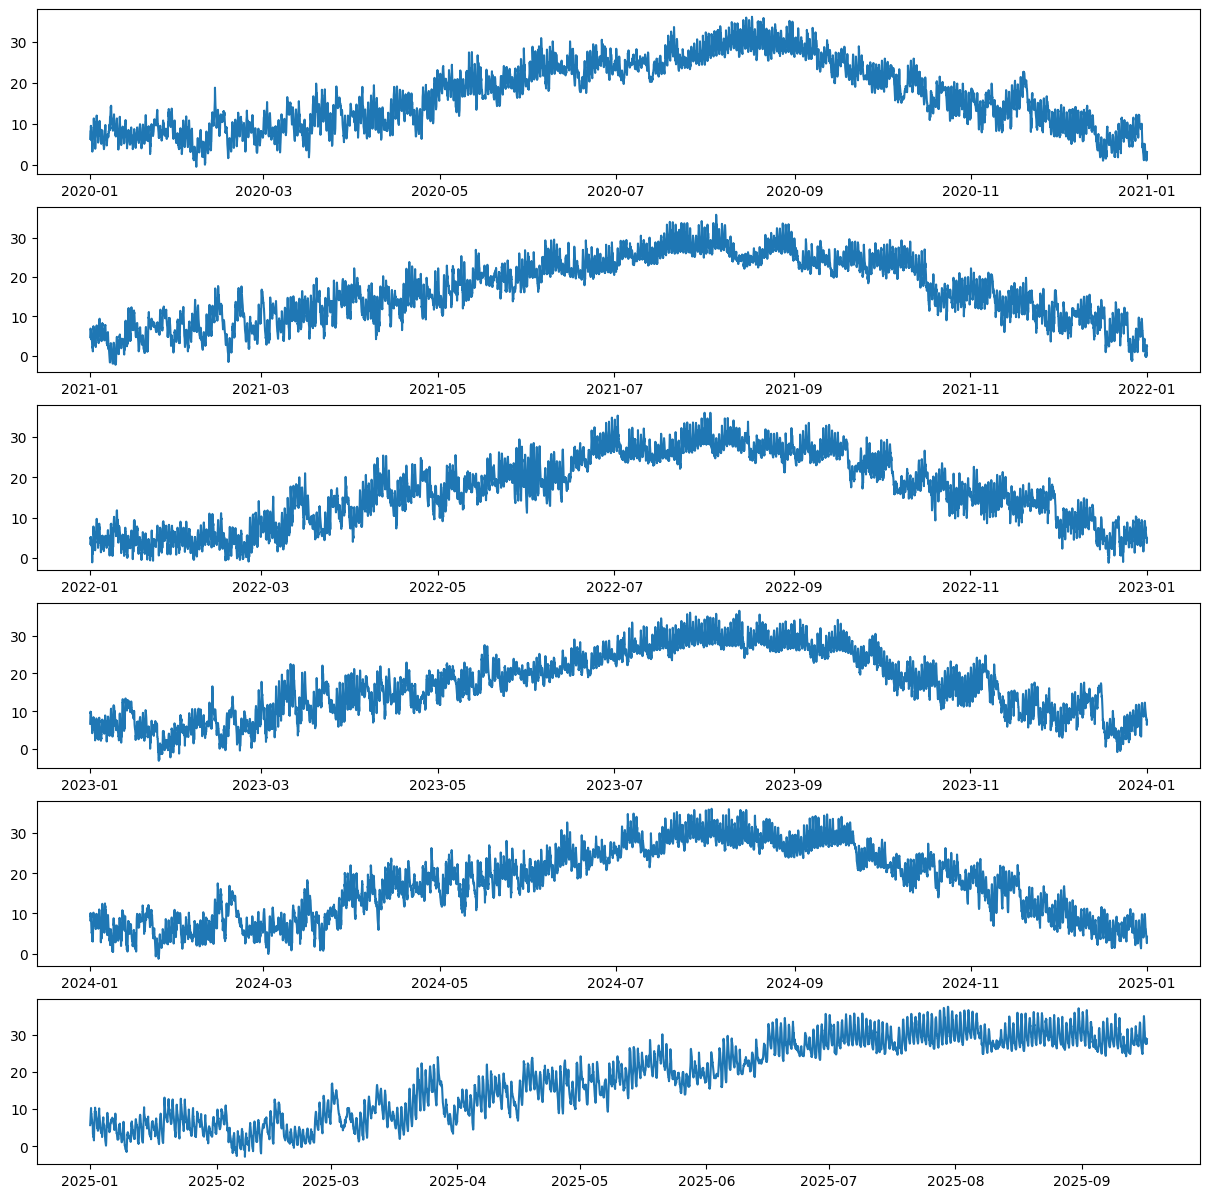

In [6]:
# Visualize Kyoto temperature trend for each year
fig, axes = plt.subplots(6, 1, figsize=(15, 15))
axes.flatten()
axes[0].plot(kyoto_train_df.loc['2020-01-01 00:00:00':'2020-12-31 23:00:00']['temp'])
axes[1].plot(kyoto_train_df.loc['2021-01-01 00:00:00':'2021-12-31 23:00:00']['temp'])
axes[2].plot(kyoto_train_df.loc['2022-01-01 00:00:00':'2022-12-31 23:00:00']['temp'])
axes[3].plot(kyoto_train_df.loc['2023-01-01 00:00:00':'2023-12-31 23:00:00']['temp'])
axes[4].plot(kyoto_train_df.loc['2024-01-01 00:00:00':'2024-12-31 23:00:00']['temp'])
axes[5].plot(kyoto_train_df.loc['2025-01-01 00:00:00':]['temp'])

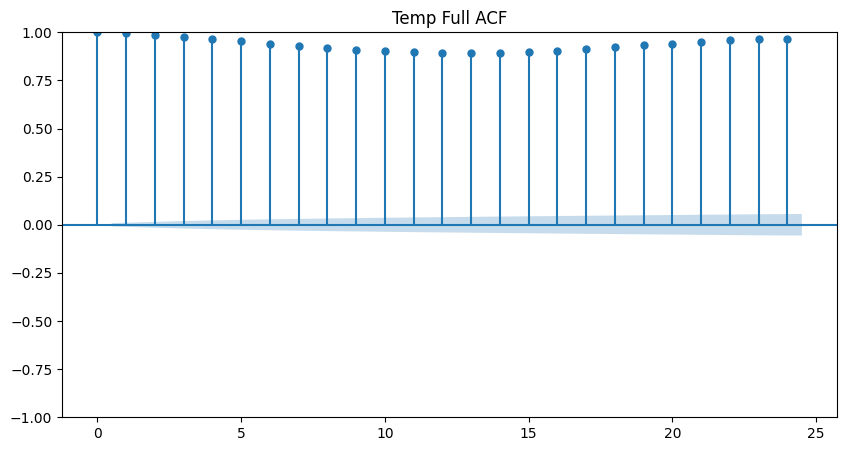

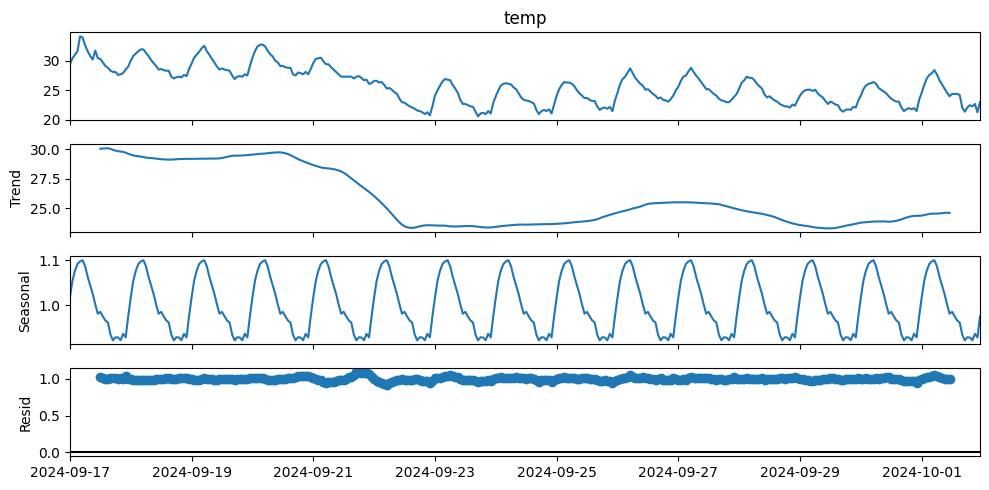

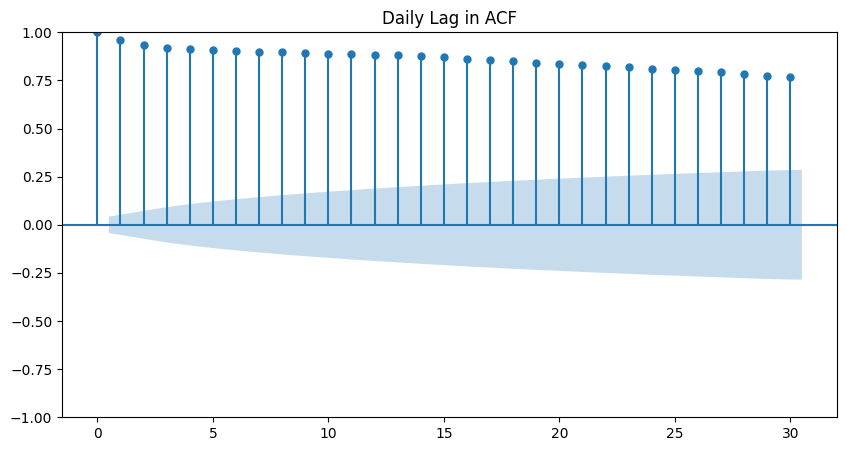

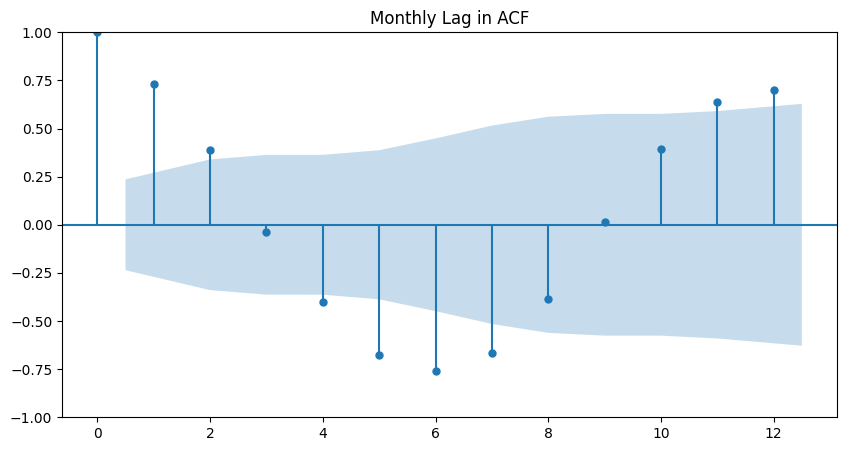

In [7]:
# Time series decomposition
plt.rcParams['figure.figsize'] = [10,5]
df_input_viz = kyoto_train_df['temp']
plot_acf(df_input_viz,lags=24)
plt.title('Temp Full ACF')
plt.show()

# Autocorrelation
df_input_viz = kyoto_train_df['temp']
df_input_viz = df_input_viz['2024-09-17':'2024-10-01']
decomposition = sm.tsa.seasonal_decompose(df_input_viz, model = 'multiplicative',period=24)
decomposition.plot()
plt.show()

df_input_viz = kyoto_train_df['temp']
df_input_viz = df_input_viz[df_input_viz.index.hour==12]
plot_acf(df_input_viz,lags=30)
plt.title('Daily Lag in ACF')
plt.show()

df_input_viz = kyoto_train_df['temp']
df_input_viz = df_input_viz[df_input_viz.index.hour==12]
df_input_viz = df_input_viz[df_input_viz.index.day==12]
plot_acf(df_input_viz,lags=12)
plt.title('Monthly Lag in ACF')
plt.show()

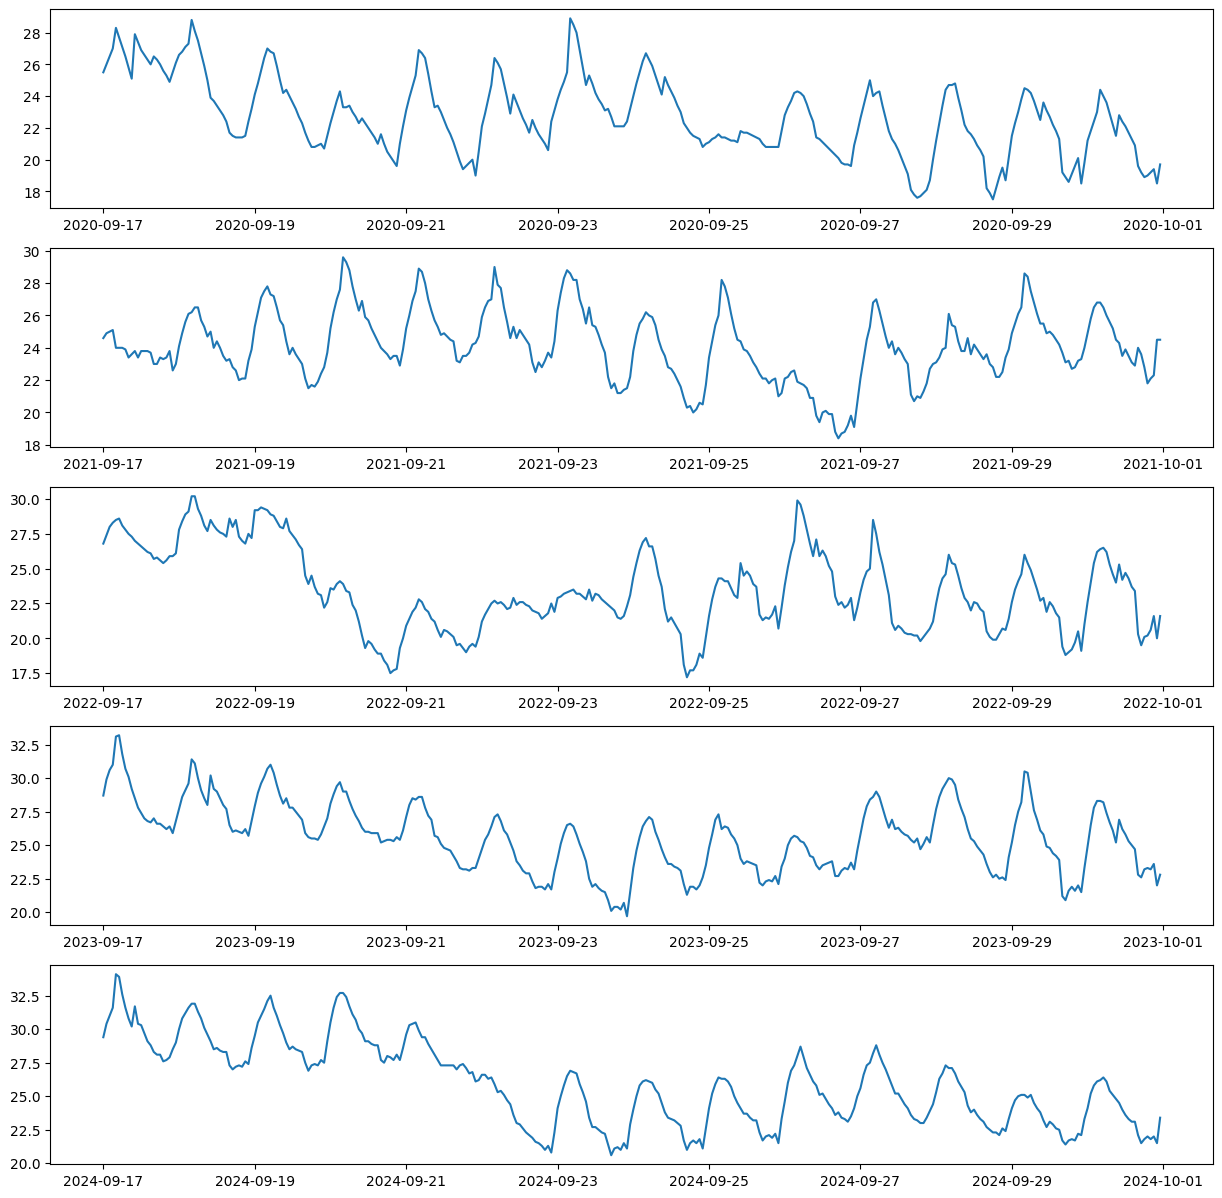

In [8]:
# Time seris on Kyoto data only
temp_per_hour = kyoto_train_df['temp']

fig, axes = plt.subplots(5, 1, figsize=(15, 15))
axes.flatten()
axes[0].plot(temp_per_hour['2020-09-17 00:00:00':'2020-09-30 23:00:00'])
axes[1].plot(temp_per_hour['2021-09-17 00:00:00':'2021-09-30 23:00:00'])
axes[2].plot(temp_per_hour['2022-09-17 00:00:00':'2022-09-30 23:00:00'])
axes[3].plot(temp_per_hour['2023-09-17 00:00:00':'2023-09-30 23:00:00'])
axes[4].plot(temp_per_hour['2024-09-17 00:00:00':'2024-09-30 23:00:00'])

In [9]:
# Fit model with no feature engineering and generate predictions for RDU
X_train = kyoto_train_df.drop(columns=['temp'])
y_train = kyoto_train_df['temp']

kyoto_model = LinearRegression()
kyoto_model.fit(X_train, y_train)

X_test = test_df.drop(columns=['temp'])
y_test = test_df['temp']
kyoto_preds = kyoto_model.predict(X_test)

In [10]:
# Calculate metrics
mae = mean_absolute_error(y_test, kyoto_preds)
mse = mean_squared_error(y_test, kyoto_preds)
r2 = r2_score(y_test, kyoto_preds)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 32.45906288441355
MAE: 4.37558947574304
R2: -0.6852479132768838


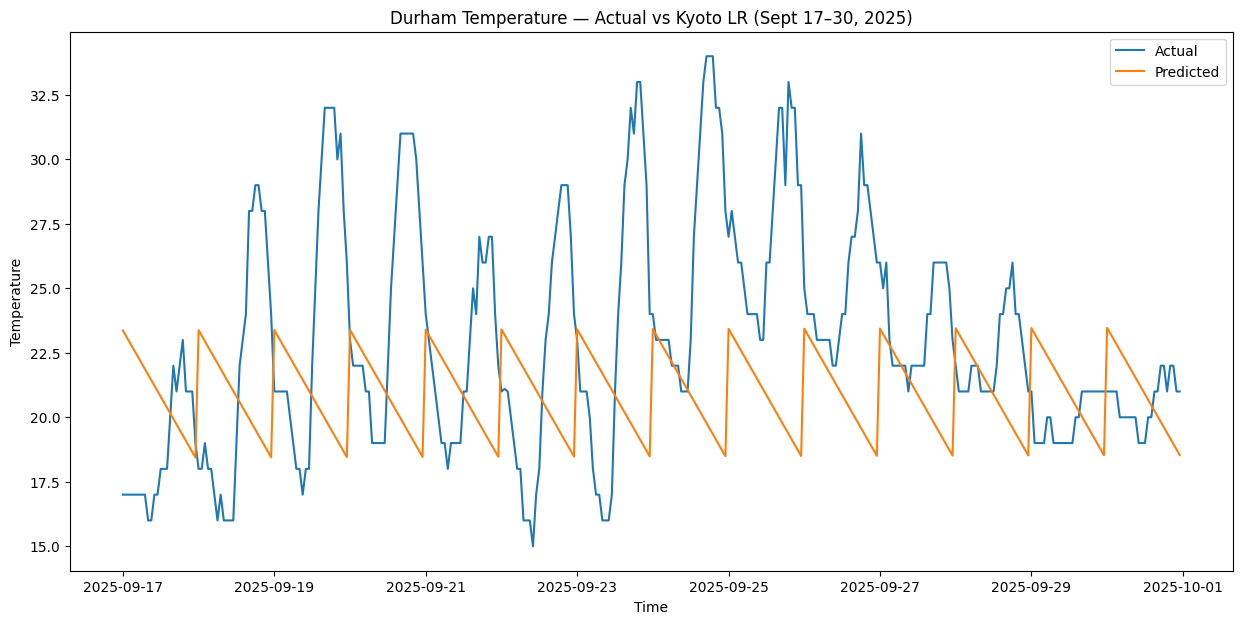

In [11]:
# Visualize actual vs. predicted
plt.figure(figsize=(15, 7))
plt.plot(test_df.index, y_test, label='Actual')
plt.plot(test_df.index, kyoto_preds, label='Predicted')
plt.title("Durham Temperature — Actual vs Kyoto LR (Sept 17–30, 2025)")
plt.xlabel("Time"); plt.ylabel("Temperature")
plt.legend()
plt.show()

In [ ]:
# Feature engineeribng
kyoto_linmodel_train = X_train.copy()

# Add calendar features to train df
kyoto_linmodel_train["dayofyear"] = kyoto_linmodel_train.index.dayofyear
kyoto_linmodel_train["dayofweek"] = kyoto_linmodel_train.index.dayofweek
kyoto_linmodel_train["hour_sin"] = np.sin(2*np.pi*kyoto_linmodel_train["hour"]/24)
kyoto_linmodel_train["hour_cos"] = np.cos(2*np.pi*kyoto_linmodel_train["hour"]/24)
kyoto_linmodel_train["doy_sin"]  = np.sin(2*np.pi*kyoto_linmodel_train["dayofyear"]/365.25)
kyoto_linmodel_train["doy_cos"]  = np.cos(2*np.pi*kyoto_linmodel_train["dayofyear"]/365.25)

for k in [2, 3]:
    kyoto_linmodel_train[f"hour_sin_{k}"] = np.sin(2*np.pi*k*kyoto_linmodel_train["hour"]/24)
    kyoto_linmodel_train[f"hour_cos_{k}"] = np.cos(2*np.pi*k*kyoto_linmodel_train["hour"]/24)
    kyoto_linmodel_train[f"doy_sin_{k}"]  = np.sin(2*np.pi*k*kyoto_linmodel_train["dayofyear"]/365.25)
    kyoto_linmodel_train[f"doy_cos_{k}"]  = np.cos(2*np.pi*k*kyoto_linmodel_train["dayofyear"]/365.25)

kyoto_linmodel_train["month_sin"] = np.sin(2*np.pi*kyoto_linmodel_train["month"]/12)
kyoto_linmodel_train["month_cos"] = np.cos(2*np.pi*kyoto_linmodel_train["month"]/12)

# Add same calendar features to test df
kyoto_linmodel_test = X_test.copy()

kyoto_linmodel_test["dayofyear"] = kyoto_linmodel_test.index.dayofyear
kyoto_linmodel_test["dayofweek"] = kyoto_linmodel_test.index.dayofweek
kyoto_linmodel_test["hour_sin"] = np.sin(2*np.pi*kyoto_linmodel_test["hour"]/24)
kyoto_linmodel_test["hour_cos"] = np.cos(2*np.pi*kyoto_linmodel_test["hour"]/24)
kyoto_linmodel_test["doy_sin"]  = np.sin(2*np.pi*kyoto_linmodel_test["dayofyear"]/365.25)
kyoto_linmodel_test["doy_cos"]  = np.cos(2*np.pi*kyoto_linmodel_test["dayofyear"]/365.25)

for k in [2, 3]:
    kyoto_linmodel_test[f"hour_sin_{k}"] = np.sin(2*np.pi*k*kyoto_linmodel_test["hour"]/24)
    kyoto_linmodel_test[f"hour_cos_{k}"] = np.cos(2*np.pi*k*kyoto_linmodel_test["hour"]/24)
    kyoto_linmodel_test[f"doy_sin_{k}"]  = np.sin(2*np.pi*k*kyoto_linmodel_test["dayofyear"]/365.25)
    kyoto_linmodel_test[f"doy_cos_{k}"]  = np.cos(2*np.pi*k*kyoto_linmodel_test["dayofyear"]/365.25)

kyoto_linmodel_test["month_sin"] = np.sin(2*np.pi*kyoto_linmodel_test["month"]/12)
kyoto_linmodel_test["month_cos"] = np.cos(2*np.pi*kyoto_linmodel_test["month"]/12)

In [ ]:
# Using autocorrelation lags from EDA
# Just from previous hour and previous day at same hour
for i in kyoto_linmodel_train.index:
  if i-pd.Timedelta(days=1) in kyoto_total_df.index:
    kyoto_linmodel_train.loc[i, "previous_hour_temp"] = kyoto_total_df.loc[i-pd.Timedelta(hours=1), 'temp']
    kyoto_linmodel_train.loc[i, "previous_day_temp"] = kyoto_total_df.loc[i-pd.Timedelta(days=1), 'temp']
kyoto_linmodel_train = kyoto_linmodel_train.iloc[24:]
kyoto_linmodel_y_train = y_train.copy()
kyoto_linmodel_y_train = kyoto_linmodel_y_train.iloc[24:]

for i in kyoto_linmodel_test.index:
  kyoto_linmodel_test.loc[i, "previous_hour_temp"] = kyoto_total_df.loc[i-pd.Timedelta(hours=1), 'temp']
  kyoto_linmodel_test.loc[i, "previous_day_temp"] = kyoto_total_df.loc[i-pd.Timedelta(days=1), 'temp']

In [ ]:
# Fit to new model and calculate metrics
kyoto_lr_model_1 = LinearRegression()
kyoto_lr_model_1.fit(kyoto_linmodel_train, kyoto_linmodel_y_train)
kyoto_lr1_preds = kyoto_lr_model_1.predict(kyoto_linmodel_test)

mse = mean_squared_error(y_test, kyoto_lr1_preds)
mae = mean_absolute_error(y_test, kyoto_lr1_preds)
r2 = r2_score(y_test, kyoto_lr1_preds)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

MSE: 43.95
MAE: 5.58
R2: -1.28


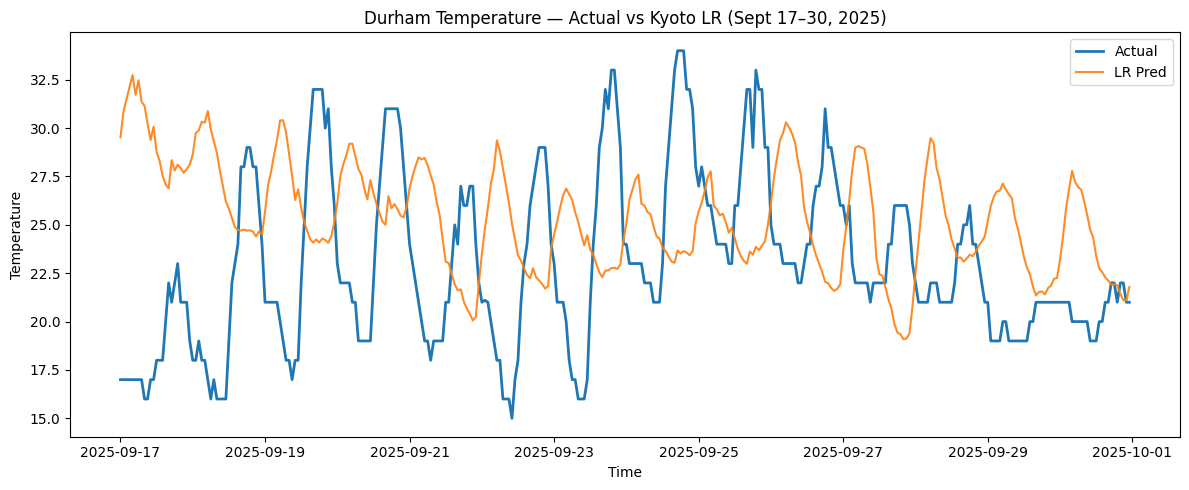

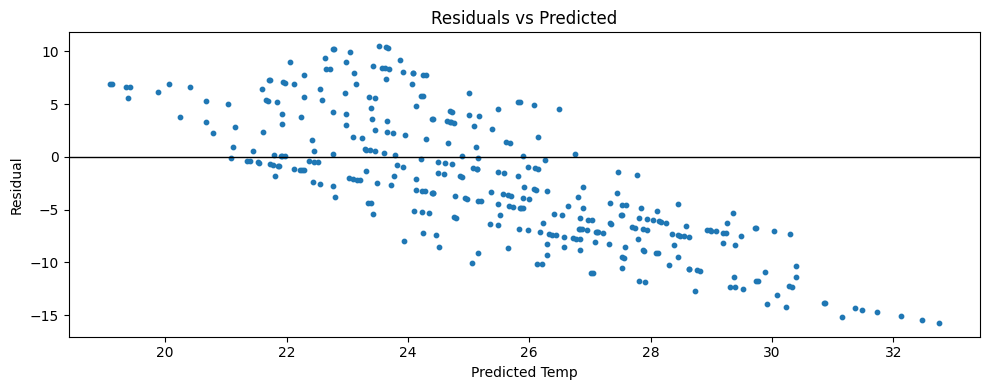

In [ ]:
# Plot actual vs. predicted
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
plt.plot(y_test.index, kyoto_lr1_preds, label="LR Pred", alpha=0.9)
plt.title("Durham Temperature — Actual vs Kyoto LR (Sept 17–30, 2025)")
plt.xlabel("Time"); plt.ylabel("Temperature")
plt.legend(); plt.tight_layout(); plt.show()

# Plot residuals
residuals = y_test.values - kyoto_lr1_preds
plt.figure(figsize=(10,4))
plt.scatter(kyoto_lr1_preds, residuals, s=10)
plt.axhline(0, color="k", linewidth=1)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Temp"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

Conducting feature engineering on the Kyoto dataset seems to generate worse predictions then using the pure date features.

## Random Forest

For the second model, we want to use a non linear model to better capture interactions and seasonality. A couple of different models we could use to do this would be RandomForest or Xgboost.

In [ ]:
# Data Preparation

# Split into everything before Sept 17th and test
train_df = all_df[all_df.index < '2025-09-17 00:00:00'].copy()
test_df = all_df[all_df.index >= '2025-09-17 00:00:00'].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Date range - Train: {train_df.index.min()} to {train_df.index.max()}")
print(f"Date range - Test: {test_df.index.min()} to {test_df.index.max()}")

Train shape: (50064, 5)
Test shape: (336, 5)
Train columns: ['year', 'month', 'day', 'hour', 'temp']
Date range - Train: 2020-01-01 00:00:00 to 2025-09-16 23:00:00
Date range - Test: 2025-09-17 00:00:00 to 2025-09-30 23:00:00


In [ ]:
# Calendar Features

# Basic calendar features
train_df["dayofyear"] = train_df.index.dayofyear
train_df["dayofweek"] = train_df.index.dayofweek
train_df["is_weekend"] = (train_df["dayofweek"] >= 5).astype(int)

# Base cyclical features using sin and cos
train_df["hour_sin"] = np.sin(2 * np.pi * train_df["hour"] / 24)
train_df["hour_cos"] = np.cos(2 * np.pi * train_df["hour"] / 24)
train_df["doy_sin"] = np.sin(2 * np.pi * train_df["dayofyear"] / 365.25)
train_df["doy_cos"] = np.cos(2 * np.pi * train_df["dayofyear"] / 365.25)

# Higher order
for k in [2, 3]:
    train_df[f"hour_sin_{k}"] = np.sin(2 * np.pi * k * train_df["hour"] / 24)
    train_df[f"hour_cos_{k}"] = np.cos(2 * np.pi * k * train_df["hour"] / 24)
    train_df[f"doy_sin_{k}"] = np.sin(2 * np.pi * k * train_df["dayofyear"] / 365.25)
    train_df[f"doy_cos_{k}"] = np.cos(2 * np.pi * k * train_df["dayofyear"] / 365.25) #Used claude code with help thinking of this on 10/12

# Monthly cycle
train_df["month_sin"] = np.sin(2 * np.pi * train_df["month"] / 12)
train_df["month_cos"] = np.cos(2 * np.pi * train_df["month"] / 12)

# Apply same transformations to test set
test_df["dayofyear"] = test_df.index.dayofyear
test_df["dayofweek"] = test_df.index.dayofweek
test_df["is_weekend"] = (test_df["dayofweek"] >= 5).astype(int)

test_df["hour_sin"] = np.sin(2 * np.pi * test_df["hour"] / 24)
test_df["hour_cos"] = np.cos(2 * np.pi * test_df["hour"] / 24)
test_df["doy_sin"] = np.sin(2 * np.pi * test_df["dayofyear"] / 365.25)
test_df["doy_cos"] = np.cos(2 * np.pi * test_df["dayofyear"] / 365.25)

for k in [2, 3]:
    test_df[f"hour_sin_{k}"] = np.sin(2 * np.pi * k * test_df["hour"] / 24)
    test_df[f"hour_cos_{k}"] = np.cos(2 * np.pi * k * test_df["hour"] / 24)
    test_df[f"doy_sin_{k}"] = np.sin(2 * np.pi * k * test_df["dayofyear"] / 365.25)
    test_df[f"doy_cos_{k}"] = np.cos(2 * np.pi * k * test_df["dayofyear"] / 365.25)

test_df["month_sin"] = np.sin(2 * np.pi * test_df["month"] / 12)
test_df["month_cos"] = np.cos(2 * np.pi * test_df["month"] / 12)

print(f"After calendar features - Train shape: {train_df.shape}, Test shape: {test_df.shape}")

After calendar features - Train shape: (50064, 22), Test shape: (336, 22)


In [ ]:
# Lag Features

# Lag hours
lag_hours = [1, 3, 6, 12, 24, 48]

# Lags for training data
for h in lag_hours:
    train_df[f"temp_lag_{h}h"] = train_df["temp"].shift(h)

# Rolling statistics on training data
train_df["temp_rollmean_24h"] = train_df["temp"].shift(1).rolling(24, min_periods=12).mean()
train_df["temp_rollstd_24h"] = train_df["temp"].shift(1).rolling(24, min_periods=12).std()
train_df["temp_rollmean_168h"] = train_df["temp"].shift(1).rolling(168, min_periods=24).mean()

# Create lags for test data
combined_temp = pd.concat([train_df[["temp"]], test_df[["temp"]]])

# For each test timestamp, look back into the combined series (used Claude to help with this code 10/13/25 3:47pm )
for h in lag_hours:
    lagged_values = combined_temp["temp"].shift(h)
    test_df[f"temp_lag_{h}h"] = lagged_values.loc[test_df.index]

# Rolling statistics for test data
rollmean_24h = combined_temp["temp"].shift(1).rolling(24, min_periods=12).mean()
rollstd_24h = combined_temp["temp"].shift(1).rolling(24, min_periods=12).std()
rollmean_168h = combined_temp["temp"].shift(1).rolling(168, min_periods=24).mean()

test_df["temp_rollmean_24h"] = rollmean_24h.loc[test_df.index]
test_df["temp_rollstd_24h"] = rollstd_24h.loc[test_df.index]
test_df["temp_rollmean_168h"] = rollmean_168h.loc[test_df.index]

print(f"After lag features - Train shape: {train_df.shape}, Test shape: {test_df.shape}")
print(f"Lag columns added: {[col for col in train_df.columns if 'lag' in col or 'roll' in col]}")

# Check for NaN values
print(f"\nNaN counts in train:\n{train_df.isnull().sum()}")
print(f"\nNaN counts in test:\n{test_df.isnull().sum()}")

After lag features - Train shape: (50064, 31), Test shape: (336, 31)
Lag columns added: ['temp_lag_1h', 'temp_lag_3h', 'temp_lag_6h', 'temp_lag_12h', 'temp_lag_24h', 'temp_lag_48h', 'temp_rollmean_24h', 'temp_rollstd_24h', 'temp_rollmean_168h']

NaN counts in train:
year                   0
month                  0
day                    0
hour                   0
temp                   0
dayofyear              0
dayofweek              0
is_weekend             0
hour_sin               0
hour_cos               0
doy_sin                0
doy_cos                0
hour_sin_2             0
hour_cos_2             0
doy_sin_2              0
doy_cos_2              0
hour_sin_3             0
hour_cos_3             0
doy_sin_3              0
doy_cos_3              0
month_sin              0
month_cos              0
temp_lag_1h            1
temp_lag_3h            3
temp_lag_6h            6
temp_lag_12h          12
temp_lag_24h          24
temp_lag_48h          48
temp_rollmean_24h     12
temp_rol

In [ ]:
# Prepare final x and y

target = "temp"

# Get all feature columns
feature_cols = [c for c in train_df.columns if c != target]

# Drop rows with NaN values
train_clean = train_df.dropna().copy()
test_clean = test_df.dropna().copy()

# Create X and y splits
X_train = train_clean[feature_cols]
y_train = train_clean[target]
X_test = test_clean[feature_cols]
y_test = test_clean[target]

print(f"Final shapes after dropping NaN:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Feature list: {feature_cols[:10]}...")

# Verify no NaN values remain
print(f"\nNaN check:")
print(f"  X_train NaNs: {X_train.isnull().sum().sum()}")
print(f"  X_test NaNs: {X_test.isnull().sum().sum()}")

Final shapes after dropping NaN:
  X_train: (50016, 30), y_train: (50016,)
  X_test: (336, 30), y_test: (336,)

Number of features: 30
Feature list: ['year', 'month', 'day', 'hour', 'dayofyear', 'dayofweek', 'is_weekend', 'hour_sin', 'hour_cos', 'doy_sin']...

NaN check:
  X_train NaNs: 0
  X_test NaNs: 0


In [ ]:
# Model Training
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import time

# Create pipeline
rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=100,
        max_depth=12,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

print("Training Random Forest model...")
start_time = time.time()

# Just train on the full training set
# (NOTE: already did cross validation to get those hyperparameters, took out for runtime purposes)
rf_pipe.fit(X_train, y_train)
best_rf = rf_pipe

Training Random Forest model...


In [ ]:
#  Final Evaluation on Test Set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on held-out test set
rf_preds = best_rf.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, rf_preds)
mse = mean_squared_error(y_test, rf_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_preds)

print("="*50)
print("FINAL TEST SET PERFORMANCE")
print("="*50)
print(f"Mean Absolute Error (MAE):  {mae:.3f}°C")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}°C")
print(f"R² Score: {r2:.4f}")
print("="*50)

# Calculate additional useful metrics
residuals = y_test.values - rf_preds
print(f"\nResidual Statistics:")
print(f"  Mean residual: {np.mean(residuals):.3f}°C")
print(f"  Std of residuals: {np.std(residuals):.3f}°C")
print(f"  Max overestimate: {np.min(residuals):.3f}°C")
print(f"  Max underestimate: {np.max(residuals):.3f}°C")

# Error distribution
within_1deg = np.sum(np.abs(residuals) <= 1.0) / len(residuals) * 100
within_2deg = np.sum(np.abs(residuals) <= 2.0) / len(residuals) * 100
within_3deg = np.sum(np.abs(residuals) <= 3.0) / len(residuals) * 100

FINAL TEST SET PERFORMANCE
Mean Absolute Error (MAE):  0.756°C
Root Mean Squared Error (RMSE): 0.976°C
R² Score: 0.9505

Residual Statistics:
  Mean residual: 0.140°C
  Std of residuals: 0.966°C
  Max overestimate: -3.100°C
  Max underestimate: 4.040°C


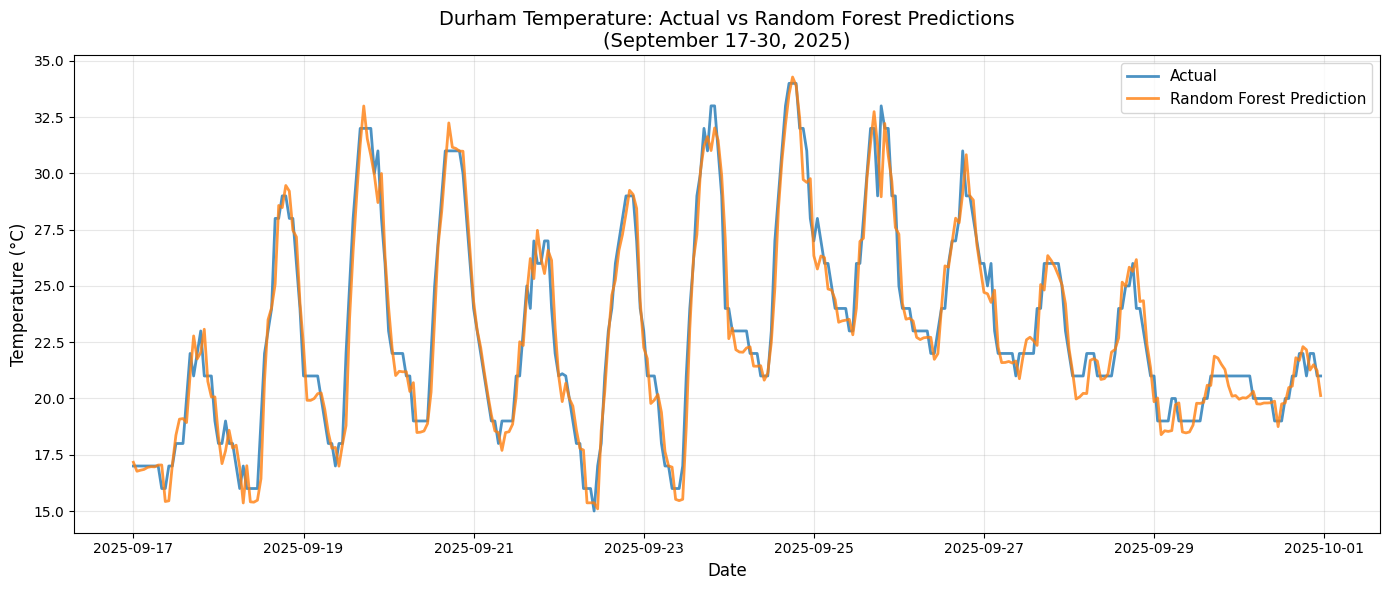

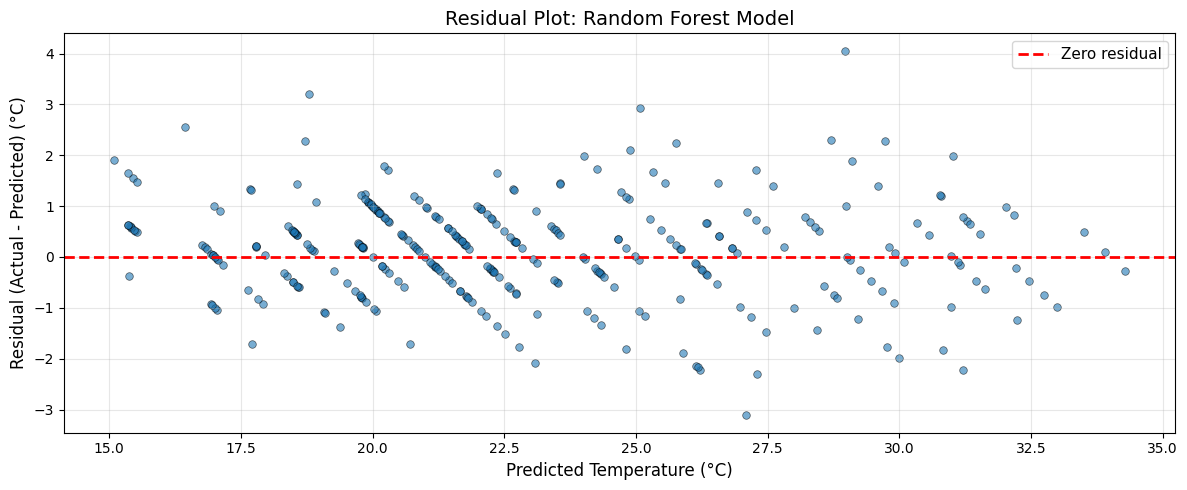

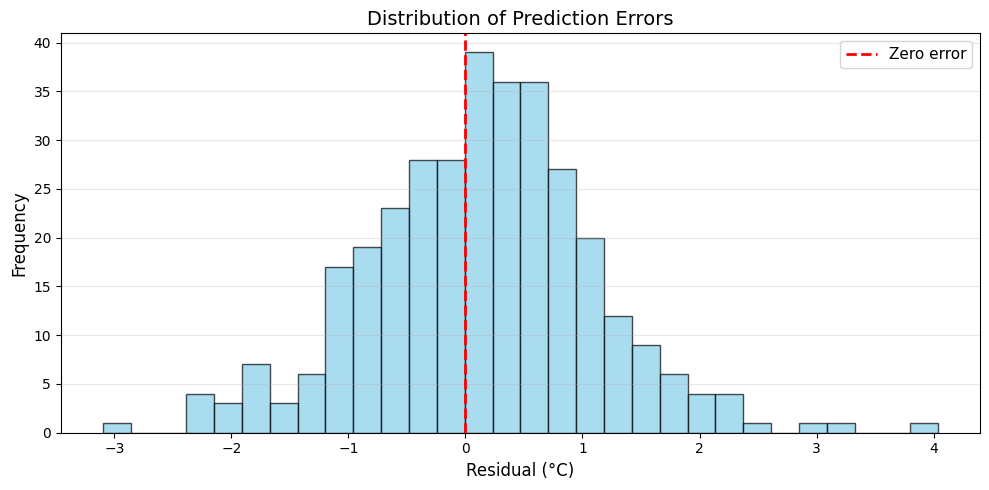


Visualization complete!


In [ ]:
# Plotting

# Plot 1: Actual vs Predicted Time Series
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2, alpha=0.8)
plt.plot(y_test.index, rf_preds, label="Random Forest Prediction", linewidth=2, alpha=0.8)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.title("Durham Temperature: Actual vs Random Forest Predictions\n(September 17-30, 2025)", fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Residual Plot
plt.figure(figsize=(12, 5))
plt.scatter(rf_preds, residuals, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=2, label="Zero residual")
plt.xlabel("Predicted Temperature (°C)", fontsize=12)
plt.ylabel("Residual (Actual - Predicted) (°C)", fontsize=12)
plt.title("Residual Plot: Random Forest Model", fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Error Distribution Histogram
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
plt.xlabel("Residual (°C)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Prediction Errors", fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nVisualization complete!")

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
           feature  importance
       temp_lag_1h    0.983502
              hour    0.003630
          hour_sin    0.002530
          hour_cos    0.001851
       temp_lag_3h    0.001421
        hour_sin_2    0.000964
 temp_rollmean_24h    0.000737
  temp_rollstd_24h    0.000708
      temp_lag_12h    0.000435
temp_rollmean_168h    0.000423
      temp_lag_24h    0.000363
       temp_lag_6h    0.000363
           doy_cos    0.000341
      temp_lag_48h    0.000328
           doy_sin    0.000251



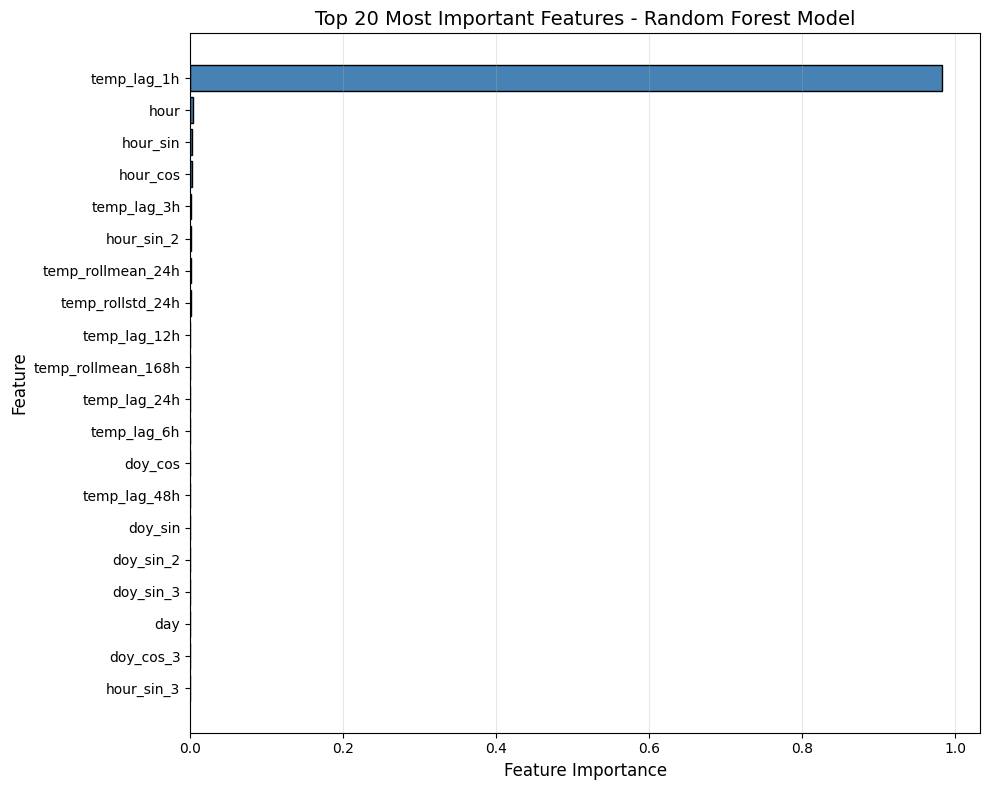


Feature Importance Summary:
Total features: 30
Top 5 features account for: 99.3% of importance
Top 10 features account for: 99.6% of importance


In [ ]:
# Feature Importance Analysis
# Extract feature importance
feature_importance = best_rf.named_steps['rf'].feature_importances_ #used Claude to get the featurei mportance function / some of this code on 10/14
feature_names = X_train.columns

# Create dataframe and sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)
print("\nTop 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))
print("="*50 + "\n")

# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 20
top_features = importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Most Important Features - Random Forest Model', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nFeature Importance Summary:")
print(f"Total features: {len(importance_df)}")
print(f"Top 5 features account for: {importance_df.head(5)['importance'].sum()*100:.1f}% of importance")
print(f"Top 10 features account for: {importance_df.head(10)['importance'].sum()*100:.1f}% of importance")